## Goals

* Generate some example Virtual Screening data.
* Construct a bayesian model for predicting probability of activity given a certain similarity score.
* Use this to compare to different queries.

In [3]:
import numpy as np
import pandas as pd
import scipy as sp
from matplotlib import pyplot as plt

from scipy.stats import beta

%matplotlib inline
import seaborn as sns

# %config InlineBackend.figure_format = 'svg'
# colors = sns.color_palette("Paired",n_colors=10)
# sns.palplot(colors)
# sns.set_palette(colors)
sns.set_context("talk")

from openeye.oechem import OEMolToSmiles
import oenotebook as oenb

from scipy.special import logit, expit
from sklearn.neighbors import KernelDensity

In [5]:
from dist import CachingMolDistance, MolFPDist

In [6]:
actives = oenb.read_file_to_dataframe("er_actives.ism", title_col="Title")
inactives = oenb.read_file_to_dataframe("er_inactives_all.ism", title_col="Title")


print(len(actives),len(inactives),1.*len(actives)/len(inactives))
oenb.render_dataframe(actives.head(3))

IOError: 

In [4]:
queries = oenb.read_file_to_dataframe("queries.ism", title_col="Title")

,Molecule,Title
0,,3ERT_lig
1,,ZINC03815458

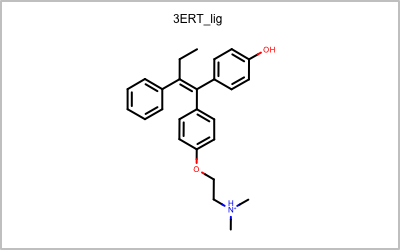
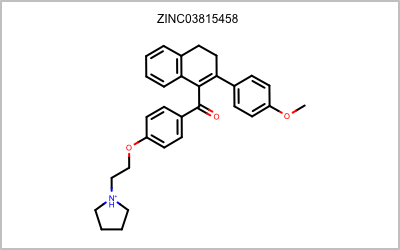

In [5]:
oenb.render_dataframe(queries)

In [6]:
actives["Active"] = True
inactives["Active"] = False

mols = pd.concat([actives,inactives], ignore_index=True)

In [7]:
# mols["SMI"] = mols.Molecule.apply(OEMolToSmiles)

In [8]:
mols["q1_sim"] = mols.Molecule.apply(lambda x: 1.-MolFPDist(queries.Molecule.iloc[0],x))
mols["q2_sim"] = mols.Molecule.apply(lambda x: 1.-MolFPDist(queries.Molecule.iloc[1],x))

In [9]:
mols.head()

,Molecule,Title,Active,q1_sim,q2_sim
0,<openeye.oechem.OEMol; proxy of <Swig Object o...,ZINC01530602,True,0.572816,0.234867
1,<openeye.oechem.OEMol; proxy of <Swig Object o...,ZINC01530690,True,0.929825,0.234450
2,<openeye.oechem.OEMol; proxy of <Swig Object o...,ZINC01531019,True,0.727273,0.251185
3,<openeye.oechem.OEMol; proxy of <Swig Object o...,ZINC01543842,True,0.203804,0.216634
4,<openeye.oechem.OEMol; proxy of <Swig Object o...,ZINC01545572,True,0.215010,0.232339


In [10]:
mols.describe()

,Active,q1_sim,q2_sim
count,401,401.000000,401.000000
mean,0.0922693,0.127546,0.144418
std,0.289767,0.073666,0.045621
min,False,0.044798,0.072464
25%,0,0.095495,0.117994
50%,0,0.111765,0.138211
75%,0,0.142276,0.157978
max,True,0.929825,0.550111


In [11]:
q1_all_kde = KernelDensity()
q1_active_kde = KernelDensity()
q1_inactive_kde = KernelDensity()

q1_all_kde.fit(logit(mols.q1_sim).reshape(-1,1))
q1_active_kde.fit(logit(mols[mols.Active].q1_sim).reshape(-1,1))
q1_inactive_kde.fit(logit(mols[~mols.Active].q1_sim).reshape(-1,1))

KernelDensity(algorithm='auto', atol=0, bandwidth=1.0, breadth_first=True,
       kernel='gaussian', leaf_size=40, metric='euclidean',
       metric_params=None, rtol=0)

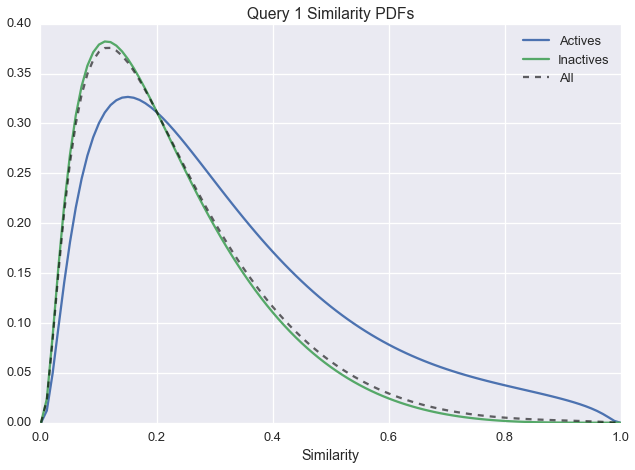

In [15]:
x = np.linspace(0.001,0.999, 101)
active_pdf = np.exp(q1_active_kde.score_samples(logit(x).reshape(-1,1)))
plt.plot(x,active_pdf,label="Actives")
inactive_pdf = np.exp(q1_inactive_kde.score_samples(logit(x).reshape(-1,1)))
plt.plot(x,inactive_pdf,label="Inactives")
plt.plot(x,np.exp(q1_all_kde.score_samples(logit(x).reshape(-1,1))),"k--",label="All",alpha=0.6)

plt.legend(loc="upper right")
plt.xlabel("Similarity")
plt.title("Query 1 Similarity PDFs")
plt.show()
plt.close()

These distributions represent the conditional probability $P( sim \vert Active )$, but what we're really interested is the posterior probability of activity given a certain score: $P(Active \vert sim)$.

We can use the Bayes Theorem specifically for two competing (i.e. mutually exclusive) states:

$$ P(Active \vert sim) = \frac{P(sim \vert Active)P(Active)}{P(sim \vert Active)P(Active) + P(sim \vert Inactive)P(Inactive)} $$

In [16]:
# Write a function to calculate posterior probability
def post_prob_active(sim, df=mols, active_kde = q1_active_kde, inactive_kde = q1_inactive_kde):
    x = logit(sim)
    prior = 1.*len(df[df.Active])/len(df)
    cond = np.exp(active_kde.score_samples(x.reshape(-1,1)))
    
    return cond*prior/(cond*prior + np.exp(inactive_kde.score_samples(x.reshape(-1,1)))*(1-prior))

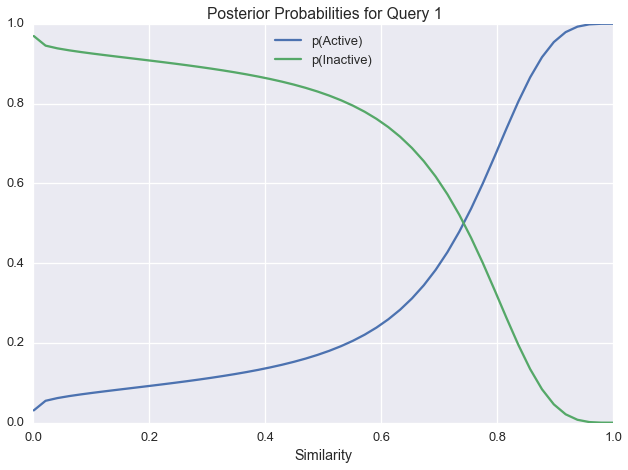

In [17]:
x = np.linspace(0.001,0.999)
plt.plot(x,post_prob_active(x),label="p(Active)")
plt.plot(x,1.-post_prob_active(x),label="p(Inactive)")
plt.legend(loc="upper center")
plt.xlabel("Similarity")
plt.title("Posterior Probabilities for Query 1")
plt.show()
plt.close()

We can do the same for query 2, and now compare the posterior probabilities of activity given a score for the two queries given this set of active and decoys.

In [18]:
q2_all_kde = KernelDensity()
q2_active_kde = KernelDensity()
q2_inactive_kde = KernelDensity()

q2_all_kde.fit(logit(mols.q2_sim.reshape(-1,1)))
q2_active_kde.fit(logit(mols[mols.Active].q2_sim.reshape(-1,1)))
q2_inactive_kde.fit(logit(mols[~mols.Active].q2_sim.reshape(-1,1)))

KernelDensity(algorithm='auto', atol=0, bandwidth=1.0, breadth_first=True,
       kernel='gaussian', leaf_size=40, metric='euclidean',
       metric_params=None, rtol=0)

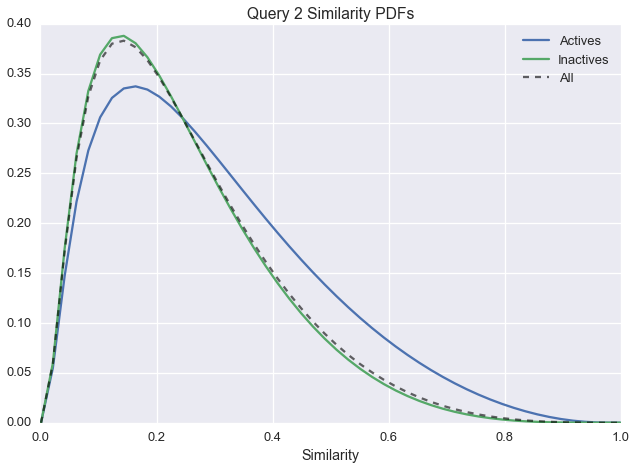

In [19]:
x = np.linspace(0.001,0.999)
active_pdf = np.exp(q2_active_kde.score_samples(logit(x.reshape(-1,1))))
plt.plot(x,active_pdf,label="Actives")
inactive_pdf = np.exp(q2_inactive_kde.score_samples(logit(x.reshape(-1,1))))
plt.plot(x,inactive_pdf,label="Inactives")
plt.plot(x,np.exp(q2_all_kde.score_samples(logit(x.reshape(-1,1)))),"k--",label="All",alpha=0.6)

# plt.xlim(0,1)
plt.legend(loc="upper right")
plt.xlabel("Similarity")
plt.title("Query 2 Similarity PDFs")
plt.show()
plt.close()

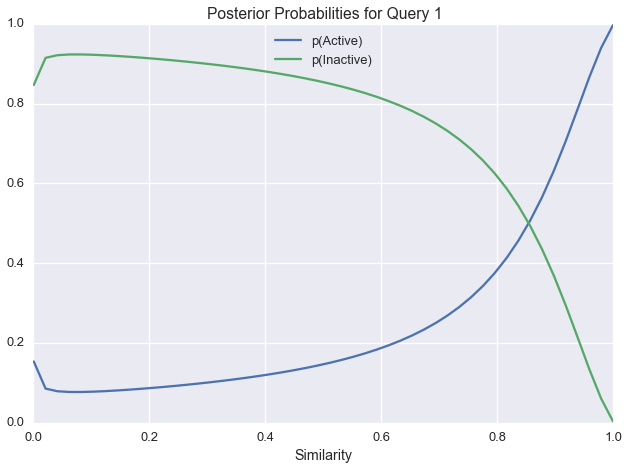

In [20]:
x = np.linspace(0.001,0.999)
plt.plot(x,post_prob_active(x,active_kde=q2_active_kde,inactive_kde=q2_inactive_kde),label="p(Active)")
plt.plot(x,1.-post_prob_active(x,active_kde=q2_active_kde,inactive_kde=q2_inactive_kde),label="p(Inactive)")
plt.legend(loc="upper center")
plt.xlabel("Similarity")
plt.title("Posterior Probabilities for Query 1")
plt.show()
plt.close()